In [2]:
import math
import numpy as np
import h5py 
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

In [3]:
#填充
def zero_pad(X, pad):
    
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0,0)), 'constant', constant_values = (0, 0))
    
    return X_pad

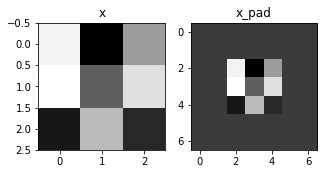

In [4]:
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [5]:
#前向传播

#卷积
def conv_single_step(a_slice_prev, W, b):
    
    s = np.multiply(a_slice_prev, W)
    Z = np.sum(s)
    Z = Z + float(b)
    
    return Z

def conv_forward(A_prev, W, b, hparameters):
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    n_H = int((n_H_prev - f + 2 * pad)/stride + 1)
    n_W = int((n_W_prev - f + 2 * pad)/stride + 1)
    
    Z = np.zeros((m, n_H, n_W, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i, :, :, :]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h*stride
                    vert_end = h*stride + f
                    horiz_start = w*stride
                    horiz_end = w*stride + f
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:, :, :, c], b[:, :, :, c])
    
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

#池化
def pool_forward(A_prev, hparameters, mode = "max"):
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    n_H = int(1 + (n_H_prev - f)/stride)
    n_W = int(1 + (n_W_prev - f)/stride)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h*stride
                    vert_end = h*stride + f
                    horiz_start = w*stride
                    horiz_end = w*stride + f
                    
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    cache = (A_prev, hparameters)
    
    return A, cache

In [6]:
#反向传播

#卷积
def conv_backward(dZ, cache):
    
    (A_prev, W, b, hparameters) = cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    (m, n_H, n_W, n_C) = dZ.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i, :, :, :]
        da_prev_pad = dA_prev_pad[i, :, :, :]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h*stride
                    vert_end = h*stride + f
                    horiz_start = w*stride
                    horiz_end = w*stride + f

                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]
                    
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    
    return dA_prev, dW, db

#池化
def create_mask_from_window(x):
    
    mask = (x == np.max(x))
    
    return mask

def distribute_value(dz, shape):
    
    (n_H, n_W) = shape
    average = dz / (n_H * n_W)
    
    a = np.ones((n_H, n_W)) * average
    
    return a

def pool_backward(dA, cache, mode = "max"):
    
    (A_prev, hparameters) = cache
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    (m, n_H_prev, n_W_prev, n_C_prev)= A_prev.shape
    (m, n_H, n_W, n_C) = dA.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    
    for i in range(m):
        a_prev = dA_prev[i, :, :, :]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = stride*h
                    vert_end = stride*h + f
                    horiz_start = stride*w
                    horiz_end = stride*w + f
                    
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask*dA[i, h, w, c]
                    
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
                        
    return dA_prev

In [35]:
#导入数据
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")#训练集
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('test_signs.h5', "r")#测试集
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

#图片显示
def image_show(index, dataset):
    index = index
    if dataset == "train":
        plt.imshow(X_train_orig[index])
        print ("y = " + str(np.squeeze(Y_train_orig[:, index])))
    elif dataset == "test":
        plt.imshow(X_test_orig[index])
        print ("y = " + str(np.squeeze(Y_test_orig[:, index])))
        
#随机批梯度
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    m = X.shape[0]                  
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    num_complete_minibatches = math.floor(m/mini_batch_size)  
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

#热编码
def convert_to_one_hot(Y, C):
    
    Y = np.eye(C)[Y.reshape(-1)].T
    
    return Y

In [36]:
#初始化

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X,Y

def initialize_parameters():
    
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters


In [37]:
#前向传播
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    Z1 = tf.nn.conv2d(X, W1, strides = [1, 1, 1, 1], padding = "SAME")
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding = "SAME")
    
    Z2 = tf.nn.conv2d(P1, W2, strides = [1, 1, 1, 1], padding = "SAME")
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding = "SAME")
    
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn = None)
    
    return Z3

#损失计算
def compute_cost(Z3, Y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

In [44]:
#整个模型

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, num_epochs = 100, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0;
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, temp_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print("%i epoch后的损失：%f" %(epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
   
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("训练集识别准确度：", train_accuracy)
        print("测试集识别准确度:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

0 epoch后的损失：1.917920
5 epoch后的损失：1.532475
10 epoch后的损失：1.014804
15 epoch后的损失：0.885137
20 epoch后的损失：0.766963
25 epoch后的损失：0.651208
30 epoch后的损失：0.613356
35 epoch后的损失：0.605931
40 epoch后的损失：0.534713
45 epoch后的损失：0.551402
50 epoch后的损失：0.496976
55 epoch后的损失：0.454438
60 epoch后的损失：0.455496
65 epoch后的损失：0.458359
70 epoch后的损失：0.450040
75 epoch后的损失：0.410687
80 epoch后的损失：0.469005
85 epoch后的损失：0.389253
90 epoch后的损失：0.363808
95 epoch后的损失：0.376132


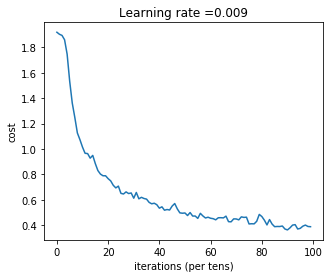

Tensor("Mean_1:0", shape=(), dtype=float32)
训练集识别准确度： 0.868519
测试集识别准确度: 0.733333


In [45]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

_, _, parameters = model(X_train, Y_train, X_test, Y_test)

In [ ]:
fname = "images/thumbs_up.jpg"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64))
plt.imshow(my_image)